In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

# MLFlow and LightGBM imports (Add Here)
import mlflow
import mlflow.lightgbm
import lightgbm as lgb

mlflow.set_experiment("lightgbm_hyperparam_tuning")

# Start MLFlow Run
mlflow.start_run()

# Log parameters
mlflow.log_param("test_size", 0.2)
mlflow.log_param("random_state", 42)

2025/03/06 04:31:39 INFO mlflow.tracking.fluent: Experiment with name 'lightgbm_hyperparam_tuning' does not exist. Creating a new experiment.


42

In [44]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-06 04:31:43,405 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-06 04:31:43,428 INFO: Initializing external client
2025-03-06 04:31:43,429 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-06 04:31:44,596 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215676


In [45]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1215676/featurestores/1203303/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [46]:
feature_store = project.get_feature_store()
print("✅ Feature Store Connected")


✅ Feature Store Connected


In [47]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides",
    read_options={"timeout": 600}
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (14.30s) 


In [48]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [49]:
print("Available columns in ts_data:", ts_data.columns.tolist())


Available columns in ts_data: ['pickup_hour', 'pickup_location_id', 'rides']


In [50]:
# Print column names to confirm
print("Available columns in ts_data:", ts_data.columns.tolist())

# Define the correct target column
correct_target_column = "rides"  # Using "rides" as the target variable

# Train-test split using the correct target column
X = ts_data.drop(columns=[correct_target_column])  # Features
y = ts_data[correct_target_column]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train-Test Split Done. Train size:", X_train.shape, "Test size:", X_test.shape)


Available columns in ts_data: ['pickup_hour', 'pickup_location_id', 'rides']
Train-Test Split Done. Train size: (1961787, 2) Test size: (490447, 2)


In [51]:
import pandas as pd

# Convert 'pickup_hour' to datetime
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

# Extract useful time-based features
ts_data["hour"] = ts_data["pickup_hour"].dt.hour
ts_data["day_of_week"] = ts_data["pickup_hour"].dt.dayofweek
ts_data["month"] = ts_data["pickup_hour"].dt.month

# Drop the original datetime column
ts_data = ts_data.drop(columns=["pickup_hour"])

# Define target variable
correct_target_column = "rides"

# Train-Test Split
X = ts_data.drop(columns=[correct_target_column])  # Features
y = ts_data[correct_target_column]  # Target

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train-Test Split Done. Train size:", X_train.shape, "Test size:", X_test.shape)

# Define baseline model
import lightgbm as lgb
import mlflow

baseline_params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.1,  # Default learning rate
    "n_estimators": 100
}

baseline_model = lgb.LGBMRegressor(**baseline_params)
baseline_model.fit(X_train, y_train)

# Predict and compute baseline MAE
y_pred_baseline = baseline_model.predict(X_test)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)

# Log baseline MAE in MLFlow
mlflow.log_metric("baseline_MAE", baseline_mae)

print(f"Baseline MAE: {baseline_mae}")


Train-Test Split Done. Train size: (1961787, 4) Test size: (490447, 4)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1961787, number of used features: 4
[LightGBM] [Info] Start training from score 16.501368
Baseline MAE: 7.348018393017165


In [52]:
from sklearn.model_selection import GridSearchCV

# Define learning rate search space
learning_rate_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2]}

# Perform grid search
grid_search_lr = GridSearchCV(lgb.LGBMRegressor(objective="regression", metric="mae"), 
                              param_grid=learning_rate_grid, 
                              scoring="neg_mean_absolute_error",
                              cv=3)

grid_search_lr.fit(X_train, y_train)

# Best learning rate
best_learning_rate = grid_search_lr.best_params_["learning_rate"]
print(f"Best Learning Rate: {best_learning_rate}")

# Log best learning rate
mlflow.log_param("best_learning_rate", best_learning_rate)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 1307858, number of used features: 4
[LightGBM] [Info] Start training from score 16.524038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 1307858, number of used features: 4
[LightGBM] [Info] Start training from score 16.494928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

0.2

In [53]:
from sklearn.experimental import enable_halving_search_cv  # Required for HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV

# Define optimized parameter grid with fewer values
param_grid = {
    "num_leaves": [20, 31],  # Reduced values
    "max_depth": [-1, 10],  # Reduced depth options
    "learning_rate": [best_learning_rate],  # Keep best learning rate
    "n_estimators": [100, 300]  # Fewer values
}

# Use faster hyperparameter tuning with HalvingGridSearchCV
grid_search_final = HalvingGridSearchCV(
    lgb.LGBMRegressor(objective="regression", metric="mae"),
    param_grid=param_grid,
    factor=2,  # More aggressive model selection
    min_resources="exhaust",
    scoring="neg_mean_absolute_error",
    cv=2,  # Reduce cross-validation folds for speed
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
grid_search_final.fit(X_train, y_train)

# Best parameters
best_params = grid_search_final.best_params_
print(f"Best Hyperparameters: {best_params}")

# Log best parameters
mlflow.log_params(best_params)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1961787, number of used features: 4
[LightGBM] [Info] Start training from score 16.501368
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 31}


In [54]:
# Train final model with best hyperparameters
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)

# Predict and compute final MAE
y_pred_final = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred_final)

# Log final MAE in MLFlow
mlflow.log_metric("final_MAE", final_mae)

print(f"Final MAE after tuning: {final_mae}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1961787, number of used features: 4
[LightGBM] [Info] Start training from score 16.501368
Final MAE after tuning: 4.887094397051163


In [55]:
mlflow.end_run()


🏃 View run colorful-turtle-723 at: https://dagshub.com/ryallavinuthnareddy/ML123.mlflow/#/experiments/6/runs/9a055ac5b0b840f48f53ef6b8b9057cf
🧪 View experiment at: https://dagshub.com/ryallavinuthnareddy/ML123.mlflow/#/experiments/6


In [56]:
decreased_MAE = baseline_mae - final_mae
print(decreased_MAE)

2.4609239959660023


In [57]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides",
    read_options={"timeout": 600}
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (14.92s) 
2025-03-06 04:34:44,595 INFO: Provenance cached data - overwriting last accessed/created training dataset from 25 to 26.


In [58]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-08-26 12:00:00+00:00,57,0
1,2023-11-23 23:00:00+00:00,67,0
2,2023-08-30 02:00:00+00:00,252,0
3,2023-08-15 02:00:00+00:00,116,2
4,2023-05-27 21:00:00+00:00,245,0


In [59]:
ts_data["pickup_hour"].min()

'2023-01-01 00:00:00+00:00'

In [60]:
ts_data["pickup_hour"].max()

'2025-03-06 01:00:00+00:00'

In [61]:
ts_data_copy = ts_data.copy()

In [62]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")
ts_data.set_index("pickup_hour", inplace=True)


In [63]:
!pip3 install statsmodels


Defaulting to user installation because normal site-packages is not writeable


In [64]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import mlflow

# Extract target variable (time-series)
y = ts_data["rides"]

# Define ARMA(2,2) model (using ARIMA with d=0)
arma_model = ARIMA(y, order=(2, 0, 2)).fit()

# Predict future values
y_pred_arma = arma_model.predict(start=len(y), end=len(y) + 10)

# Evaluate ARMA performance using MAE
arma_mae = mean_absolute_error(y[-len(y_pred_arma):], y_pred_arma)

# Log ARMA results in MLFlow
with mlflow.start_run():
    mlflow.log_param("model_type", "ARMA")
    mlflow.log_metric("arma_MAE", arma_mae)

print(f"✅ ARMA Model Trained. MAE: {arma_mae:.2f}")


🏃 View run mercurial-trout-197 at: https://dagshub.com/ryallavinuthnareddy/ML123.mlflow/#/experiments/6/runs/8b8d732a143742de8d302f93dbe2a8e6
🧪 View experiment at: https://dagshub.com/ryallavinuthnareddy/ML123.mlflow/#/experiments/6
✅ ARMA Model Trained. MAE: 18.14


In [65]:
# ARIMA(2,1,2) model (for non-stationary time-series)
arima_model = ARIMA(y, order=(2, 1, 2)).fit()

# Predict future values
y_pred_arima = arima_model.predict(start=len(y), end=len(y) + 10, typ='levels')

# Evaluate ARIMA performance using MAE
arima_mae = mean_absolute_error(y[-len(y_pred_arima):], y_pred_arima)

# Log ARIMA results in MLFlow
with mlflow.start_run():
    mlflow.log_param("model_type", "ARIMA")
    mlflow.log_metric("arima_MAE", arima_mae)

print(f"✅ ARIMA Model Trained. MAE: {arima_mae:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 290
[LightGBM] [Info] Number of data points in the train set: 122611, number of used features: 4
[LightGBM] [Info] Start training from score 16.630139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 245222, number of used features: 4
[LightGBM] [Info] Start training from score 16.472837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set:

🏃 View run flawless-loon-103 at: https://dagshub.com/ryallavinuthnareddy/ML123.mlflow/#/experiments/6/runs/541e3c1ef3af464b9aa978c4423dabda
🧪 View experiment at: https://dagshub.com/ryallavinuthnareddy/ML123.mlflow/#/experiments/6
✅ ARIMA Model Trained. MAE: 18.09


In [22]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452234 entries, 0 to 2452233
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 37.4 MB


In [23]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [24]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452234 entries, 0 to 2452233
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 37.4 MB


In [25]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [26]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01
...,...,...,...,...
2452229,2025-03-05 21:00:00,263,109,2025-03
2452230,2025-03-05 22:00:00,263,82,2025-03
2452231,2025-03-05 23:00:00,263,28,2025-03
2452232,2025-03-06 00:00:00,263,16,2025-03


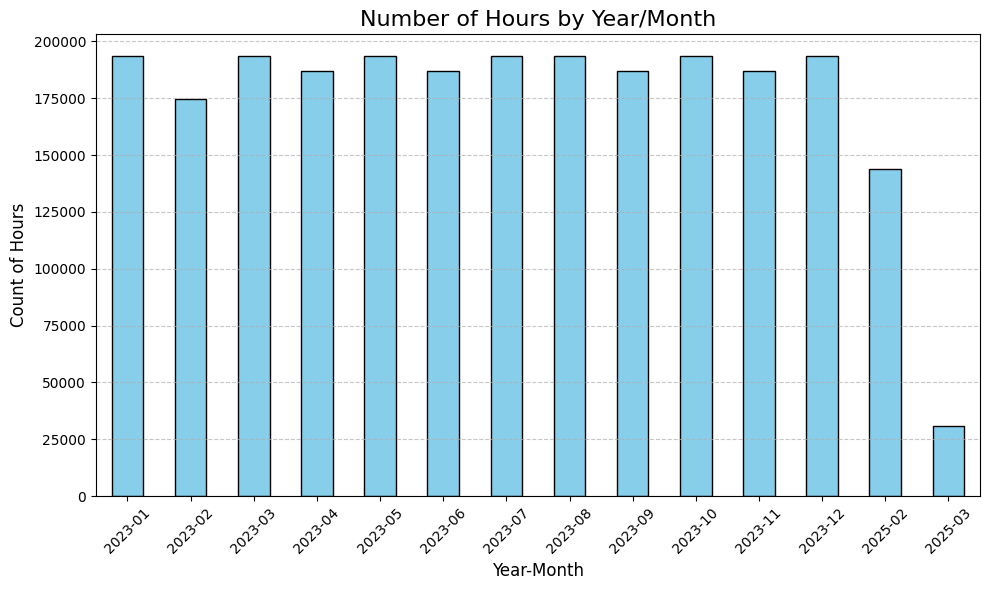

In [27]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [28]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


In [29]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [30]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [31]:
filtered_data.shape

(2277600, 3)

In [32]:
ts_data = filtered_data

In [33]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277600 entries, 0 to 2277599
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 34.8 MB


In [34]:
ts_data.head()["pickup_hour"].values

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', '2023-01-01T03:00:00.000000000',
       '2023-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [35]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [36]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91515,110,115,101,125,129,137,109,137,132,89,...,8,38,37,68,74,98,85,89,2023-12-27 13:00:00,263
91516,104,109,89,133,130,143,165,103,106,111,...,8,14,30,34,49,76,96,88,2023-12-28 12:00:00,263
91517,100,114,110,117,134,130,188,250,173,142,...,9,8,11,38,46,55,73,73,2023-12-29 11:00:00,263
91518,151,148,147,134,119,137,124,126,160,205,...,36,13,14,16,20,25,42,54,2023-12-30 10:00:00,263


In [37]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-27 13:00:00,2
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-28 12:00:00,2
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-29 11:00:00,2
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-30 10:00:00,2


In [38]:
features_copy = features.copy()

In [39]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91520, 675)

In [40]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-05 23:17:07.115907')

In [41]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(91520, 674)
(91520,)
(0, 674)
(0,)


In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91520 entries, 0 to 91519
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 470.3 MB


In [43]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [44]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 91520, number of used features: 675
[LightGBM] [Info] Start training from score 16.630299


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x30b856660>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [45]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [46]:
predictions

array([ 0.16632143,  0.16632143,  0.16632143, ..., 83.42269769,
       75.76323756, 60.66289631])

In [47]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.9355


In [48]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/Vinuthna/Downloads/Applied_ML_1st_project/sp25_taxi-main/models/lgb_model.pkl']

In [49]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [50]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('/Users/Vinuthna/Downloads/Applied_ML_1st_project/sp25_taxi-main/models/lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/317901 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2091 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48705 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1215676/models/taxi_demand_predictor_next_hour/1


Model(name: 'taxi_demand_predictor_next_hour', version: 1)

In [52]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-03-05 23:24:43,765 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 23:24:43,767 INFO: Initializing external client
2025-03-05 23:24:43,768 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 23:24:45,284 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215676

In [53]:
from src.inference import get_model_predictions

In [54]:
preds = get_model_predictions(model, features_copy)

In [55]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
91515,263,86.0
91516,263,95.0
91517,263,83.0
91518,263,76.0


In [56]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8374
